In [19]:
import sys
import numpy as np
import os
import cv2
import logging
from image_utils import standardize,distance_map_batch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
# from unet_meli import UNet,weights_init
from unet_val_2 import UNet
# from unet_val import UNet
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from shapeSorter import SimpleSegmentationDataset
from IOU_computations import *
from random import randint
import time

In [20]:
%matplotlib notebook

In [21]:
!gpustat

coeus  Fri Apr 20 16:27:45 2018
[0] TITAN X (Pascal) | 53'C,   0 % |  2541 / 12189 MB | s161362(2531M)
[1] TITAN X (Pascal) | 68'C,   0 % |  8539 / 12189 MB | mabal(8529M)
[2] TITAN X (Pascal) | 73'C,   0 % |  8541 / 12189 MB | mabal(8531M)
[3] TITAN X (Pascal) | 64'C,   0 % |  8541 / 12189 MB | mabal(8531M)
[4] TITAN X (Pascal) | 70'C,   0 % |  8541 / 12189 MB | mabal(8531M)
[5] TITAN X (Pascal) | 66'C,   0 % |  8539 / 12189 MB | mabal(8529M)
[6] TITAN X (Pascal) | 62'C,   0 % |  8541 / 12189 MB | mabal(8531M)
[7] TITAN X (Pascal) | 67'C,   0 % |  8541 / 12189 MB | mabal(8531M)


In [22]:
##########
GLOBAL_PATH='MODEL_SHAPE_DIST_TEST/'
##########

if not os.path.exists(GLOBAL_PATH):
            os.makedirs(GLOBAL_PATH)
        
#############
PATH_TRAINING='TRAINING/'
PATH_VALIDATION='VALIDATION/'
PATH_TEST='TEST/'

PATH_INPUT='INPUT/'
PATH_OUTPUT='OUTPUT/'
##############

        
INPUT_CHANNELS=3
NB_CLASSES=3

SIZE_PATCH=120
##############
MODEL_PATH_SAVE=GLOBAL_PATH+'pytorch_shape_test_DIST'
MODEL_PATH_RESTORE=''
TEST_SAVE=GLOBAL_PATH+'TEST_SAVE/'
if not os.path.exists(TEST_SAVE):
            os.makedirs(TEST_SAVE)
        
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

##############

REC_SAVE=200#2000
DROPOUT=0.2#0.9
DEFAULT_BATCH_SIZE = 32#8
DEFAULT_EPOCHS = 6#300
DEFAULT_VALID=10#100
DISPLAY_STEP=10#100

###############
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DEFAULT_FILTERS_SIZE=3
DEFAULT_LR=0.01#0.0001
DEFAULT_FILTER_WIDTH=3


################
DISTANCE_NET=True
BINS=9
THRESHOLD=20

####### TMP folder for IOU

TMP_IOU=TEST_SAVE+'TMP_IOU/'
if not os.path.exists(TMP_IOU):
            os.makedirs(TMP_IOU)

In [23]:
 class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param lr: learning rate
    """
    def __init__(self, net, batch_size=10, lr=0.0001,nb_classes=4):
        self.net = net
        self.batch_size = batch_size
        self.lr = lr
        self.nb_classes=nb_classes
    def _initialize(self, prediction_path,threshold=20,bins=15):
        
        self.optimizer = optim.Adam(self.net.parameters(),lr=self.lr)
        self.prediction_path = prediction_path
        self.threshold=threshold
        self.bins=bins
        
    
    
    def train(self, save_path='', restore_path='',  epochs=3, dropout=0.9, display_step=1, validation_batch_size=30,rec_save=1, prediction_path = '',threshold=20,bins=15,data_aug=None):
        """
        Lauches the training process
        

        :param save_path: path where to store checkpoints
        :param restore_path: path where is the model to restore is stored
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        :param prediction_path: path where to save predictions on each epoch
        """
        ###Visualize Training  loss and lr
        fig,axs =plt.subplots(1, 2,figsize=(6,3))
        draw_update([],[],fig,axs)
        
        
        
        ###Tune Learning rate
        reduce_lr_steps = [1,5, 10, 100,200]
        
        if epochs == 0:
            return save_path
        if save_path=='':
            return 'Specify a path where to store the Model'
        
        self._initialize(prediction_path,threshold,bins)
            
        ###Validation loader
          
        
        val_generator=SimpleSegmentationDataset(SIZE_PATCH, 3, alpha =1.0,virtual_size=30)
        val_loader = DataLoader(val_generator, batch_size=validation_batch_size,shuffle=False, num_workers=1)
        
        RBD=randint(0,int(val_loader.__len__())-1)
        self.store_init(val_loader,"_init",RBD)
        
        ###Training loader
        train_generator=SimpleSegmentationDataset(SIZE_PATCH, 3, alpha =1.0,virtual_size=4960)#4960
        train_loader = DataLoader(train_generator, batch_size=self.batch_size,shuffle=True, num_workers=1)
        lr_train=np.zeros(train_loader.__len__()*epochs)
        
        
        if restore_path=='':
            loss_train,avg_loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif=save_metrics(epochs,train_loader.__len__(),TEST_SAVE,'w')
            
            print('Model trained from scratch')
        else:
            loss_train,avg_loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif=save_metrics(epochs,train_loader.__len__(),TEST_SAVE,'a')
            self.net.load_state_dict(torch.load(restore_path))
            print('Model loaded from {}'.format(restore_path))

        logging.info("Start optimization")

        counter=0
        
        for epoch in range(epochs):
            ##tune learning reate
            if epoch in reduce_lr_steps:
                self.lr = self.lr * 0.3
                self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
            
            total_loss = 0
            error_tot=0
            train_loader = DataLoader(train_generator, batch_size=self.batch_size,shuffle=True, num_workers=1)
            for i_batch,sample in enumerate(train_loader):
                
                ##Real Batch
                batch_x=standardize(sample['input'])
                batch_y=sample['groundtruth']
        
                ##Variables input and output transformed for cuda
                X = Variable(batch_x.float())
                X=X.permute(0,3,1,2).cuda()  
                Y = Variable(batch_y.float())
                Y=Y.cuda()
                Y_dist=distance_map_batch(batch_y,self.threshold,self.bins)
                Y_dist = Variable(Y_dist.float())
                Y_dist=Y_dist.cuda()
                
                ## Fwd+loss+bckwrd
                probs_dist,probs_seg=predict(self.net,X)
                
                self.optimizer.zero_grad()
                loss_seg=criterion(Y,probs_seg)
                loss_dist=criterion(Y_dist,probs_dist)
                loss=loss_seg+loss_dist
                loss.backward()
                self.optimizer.step()
                
                ## Store tracking training (loss+lr)
                total_loss+=loss.data[0]
                loss_train[counter]=loss.data[0]
                lr_train[counter]=self.lr

                counter+=1
                
                if i_batch % display_step == 0:
                    self.output_training_stats(i_batch,X,Y,Y_dist)
                    draw_update(loss_train,lr_train,fig,axs)
                    
                if counter % rec_save == 0:
                    torch.save(self.net.state_dict(),save_path + 'CP{}.pth'.format(counter))
                    print('Checkpoint {} saved !'.format(counter))
            
            avg_loss_train[epoch]=total_loss/train_loader.__len__()
            file_train.write(str(avg_loss_train[epoch])+'\n')
            logging.info(" Training {:}, Minibatch Loss= {:.4f}".format("epoch_%s"%epoch,avg_loss_train[epoch] ))
            
            error_rate_v,loss_v,iou_v,iou_acc_v,f1_v=self.store_validation(val_loader, "epoch_%s"%epoch,RBD,save_patches=False)
            IOU_verif[epoch]=iou_v
            IOU_acc_verif[epoch]=iou_acc_v
            f1_IOU_verif[epoch]=f1_v
            loss_verif[epoch]=loss_v
            
            IOU_file_verif.write(str(IOU_verif[epoch])+'\n')
            IOU_acc_file_verif.write(str(IOU_acc_verif[epoch])+'\n')
            f1_IOU_file_verif.write(str(f1_IOU_verif[epoch])+'\n')
            file_verif.write(str(loss_verif[epoch])+'\n')
            
        error_rate_v,loss_v,iou_v,iou_acc_v,f1_v=self.store_validation(val_loader, "epoch_%s"%epoch,RBD,save_patches=True)
        time.sleep(4)
        plt.close(fig)
        return save_path, loss_train,avg_loss_train,loss_verif,IOU_verif,IOU_acc_verif,f1_IOU_verif      
    
    def output_training_stats(self, step, batch_x, batch_y,batch_y_dist):
        # Calculate batch loss and accuracy

        predictions_dist,predictions_seg=predict(self.net,batch_x)
        loss_seg=criterion(batch_y,predictions_seg)
        loss_dist=criterion(batch_y_dist,predictions_dist)
        loss=loss_seg+loss_dist
        loss=loss.data[0]
        predictions=predictions_seg.data.cpu().numpy()
        groundtruth=batch_y.data.cpu().numpy()
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Minibatch error= {:.1f}%".format(step,loss,error_rate(predictions, groundtruth)))
        
        
        
        
    def store_init(self,val_loader,name,random_batch_display,*,save_patches=True):
        loss_v=0
        error_rate_v=0

        for i_batch,sample in enumerate(val_loader):
            batch_x=standardize(sample['input'])
            batch_y=sample['groundtruth']

            
            X = Variable(batch_x.float())
            X=X.permute(0,3,1,2).cuda()  
            Y = Variable(batch_y.float())
            Y=Y.cuda()
            y_dist=distance_map_batch(batch_y,self.threshold,self.bins)
            Y_dist = Variable(y_dist.float())
            Y_dist=Y_dist.cuda()
    
            
            probs_dist,probs_seg=predict(self.net,X)
            loss_seg=criterion(Y,probs_seg)
            
            loss_dist=criterion(Y_dist,probs_dist)
            loss=loss_seg+loss_dist
            
            loss_v+=loss.data[0]
            prediction_seg_v=probs_seg.data.cpu().numpy()
            groundtruth_seg_v=np.asarray(batch_y)
            prediction_dist_v=probs_dist.data.cpu().numpy()
            groundtruth_dist=np.asarray(y_dist)
            
            error_rate_v+=error_rate(prediction_seg_v,groundtruth_seg_v)
            if i_batch==random_batch_display:    
                batch_x=np.asarray(batch_x)
                plot_summary(prediction_seg_v,groundtruth_seg_v,prediction_dist_v,groundtruth_dist,batch_x,name,self.prediction_path,save_patches)

    
                         
        loss_v/=val_loader.__len__()   
        error_rate_v/=val_loader.__len__()  
        logging.info("Verification  loss= {:.4f},error= {:.1f}%".format(loss_v,error_rate_v))
        
    
    def store_validation(self,val_loader, name,random_batch_display,*,save_patches=True):
        loss_v=0
        iou_v=0
        iou_acc_v=0
        f1_v=0
        error_rate_v=0

        for i_batch,sample in enumerate(val_loader):
            
            batch_x=standardize(sample['input'])
            batch_y=sample['groundtruth']
    
            X = Variable(batch_x.float())
            X=X.permute(0,3,1,2).cuda()  
            Y = Variable(batch_y.float())
            Y=Y.cuda()
            y_dist=distance_map_batch(batch_y,self.threshold,self.bins)
            Y_dist = Variable(y_dist.float())
            Y_dist=Y_dist.cuda()
            
            
            probs_dist,probs_seg=predict(self.net,X)
            loss_seg=criterion(Y,probs_seg)
            loss_dist=criterion(Y_dist,probs_dist)
            loss=loss_seg+loss_dist
            
            loss_v+=loss.data[0]
            
            prediction_seg_v=probs_seg.data.cpu().numpy()
            groundtruth_seg_v=np.asarray(batch_y)
            prediction_dist_v=probs_dist.data.cpu().numpy()
            groundtruth_dist=np.asarray(y_dist)
            
            iou_acc,f1,iou=predict_score_batch(TMP_IOU,np.argmax(groundtruth_seg_v,3),np.argmax(prediction_seg_v,3))
            
            iou_acc_v+=iou_acc
            iou_v+=iou
            f1_v+=f1
            error_rate_v+=error_rate(prediction_seg_v,groundtruth_seg_v)
            
            if i_batch==random_batch_display:   
                batch_x=np.asarray(batch_x)
                plot_summary(prediction_seg_v,groundtruth_seg_v,prediction_dist_v,groundtruth_dist,batch_x,name,self.prediction_path,save_patches)
            

        loss_v/=val_loader.__len__()   
        iou_v/=val_loader.__len__()  
        iou_acc_v/=val_loader.__len__()  
        f1_v/=val_loader.__len__()  
        error_rate_v/=val_loader.__len__()  

        logging.info("Verification  loss= {:.4f},error rate= {:.1f}%, IOU = {:.4f}, IOU Precision = {:.4f}%, F1 IOU= {:.4f}%".format(loss_v,error_rate_v,iou_v,iou_acc_v,f1_v))


        return error_rate_v,loss_v,iou_v,iou_acc_v,f1_v

In [24]:
loss_fn=nn.CrossEntropyLoss()
def criterion(y,y_):
#     y=y.permute(0,3,1,2)
#     y_=y_.permute(0,3,1,2)
    
#     loss=Fu.binary_cross_entropy_with_logits(y_,y)
    
    y = y.contiguous().view(-1,y.size()[-1])
    y_ = y_.contiguous().view(-1,y.size()[-1])
    y = y.max(-1)[1]
    loss = loss_fn(y_,y)
    
    return loss

def predict(net,batch_x):
    

    logits_dist,logits_seg=net(batch_x)
    return logits_dist.permute(0,2,3,1),logits_seg.permute(0,2,3,1)


def save_metrics(epochs,training_len,prediction_path,mode):
    #STORE loss for ANALYSIS
    loss_train=np.zeros(epochs*training_len)
    avg_loss_train=np.zeros(epochs)
    file_train = open(prediction_path+'avg_loss_train.txt',mode) 
    loss_verif=np.zeros(epochs)
    file_verif = open(prediction_path+'loss_verif.txt',mode) 
    #STORE IOU for ANALYSIS
    IOU_verif=np.zeros(epochs)
    IOU_file_verif = open(prediction_path+'iou_verif.txt',mode)
    #STORE IOU_ACC for ANALYSIS
    IOU_acc_verif=np.zeros(epochs)
    IOU_acc_file_verif = open(prediction_path+'iou_acc_verif.txt',mode)
    #STORE f1_IOU for ANALYSIS
    f1_IOU_verif=np.zeros(epochs)
    f1_IOU_file_verif = open(prediction_path+'f1_iou_verif.txt',mode) 
    
    return loss_train,avg_loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif
def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """

    return 100.0 - (
        100.0 *
        np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
        (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]))
def plot_summary(predictions,labels,prediction_dist,groundtruth_dist,pansharp,epoch,prediction_path,save_patches):

    fig,axs=plt.subplots(5, len(pansharp),figsize=(5*len(pansharp),15))

    labels_seg=np.argmax(labels, 3) 
    logits_seg=np.argmax(predictions, 3)
    labels_dist=np.argmax(groundtruth_dist, 3) 
    logits_dist=np.argmax(prediction_dist, 3)

    for i in range(len(pansharp)):

        axs[0,i].imshow(pansharp[i])
        axs[1,i].imshow(labels_seg[i]) 
        axs[2,i].imshow(logits_seg[i])
        axs[3,i].imshow(labels_dist[i],cmap="jet")
        axs[4,i].imshow(logits_dist[i],cmap="jet")
        
        
        if save_patches:
            plt.imsave(prediction_path+epoch+'_Panchro_'+str(i)+'.jpg',pansharp[i]/np.amax(pansharp[i]))
            plt.imsave(prediction_path+epoch+'_Groundtruth_'+str(i)+'.jpg',labels_seg[i])
            plt.imsave(prediction_path+epoch+'_Predictions_'+str(i)+'.jpg',logits_seg[i])
            plt.imsave(prediction_path+epoch+'_Groundtruth_dist_'+str(i)+'.jpg',labels_dist[i],cmap="jet")
            plt.imsave(prediction_path+epoch+'_Predictions_dist_'+str(i)+'.jpg',logits_dist[i],cmap="jet")

    fig.canvas.draw()
    time.sleep(4)
    plt.close(fig)

def draw_update(loss,lr,fig,axs):
    
    if len(loss)==0 and len(lr)==0:

        axs[0].set_ylim(0,0.001)
        axs[0].set_title('Loss train')
        axs[1].set_ylim(0,1)
        axs[0].set_title('Learning rate')
    else:
        global_step=len(loss)
        ite=np.arange(global_step)
        axs[0].clear()
        axs[1].clear()
        line1, = axs[0].plot(ite, loss, 'r-') 
        line2, = axs[1].plot(ite, lr, 'b-') 
        fig.canvas.draw()
        time.sleep(4)

<IPython.core.display.Javascript object>


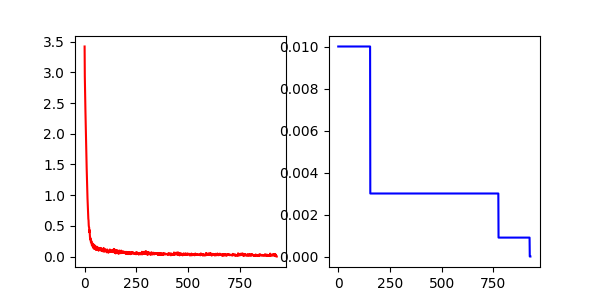

/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


<IPython.core.display.Javascript object>


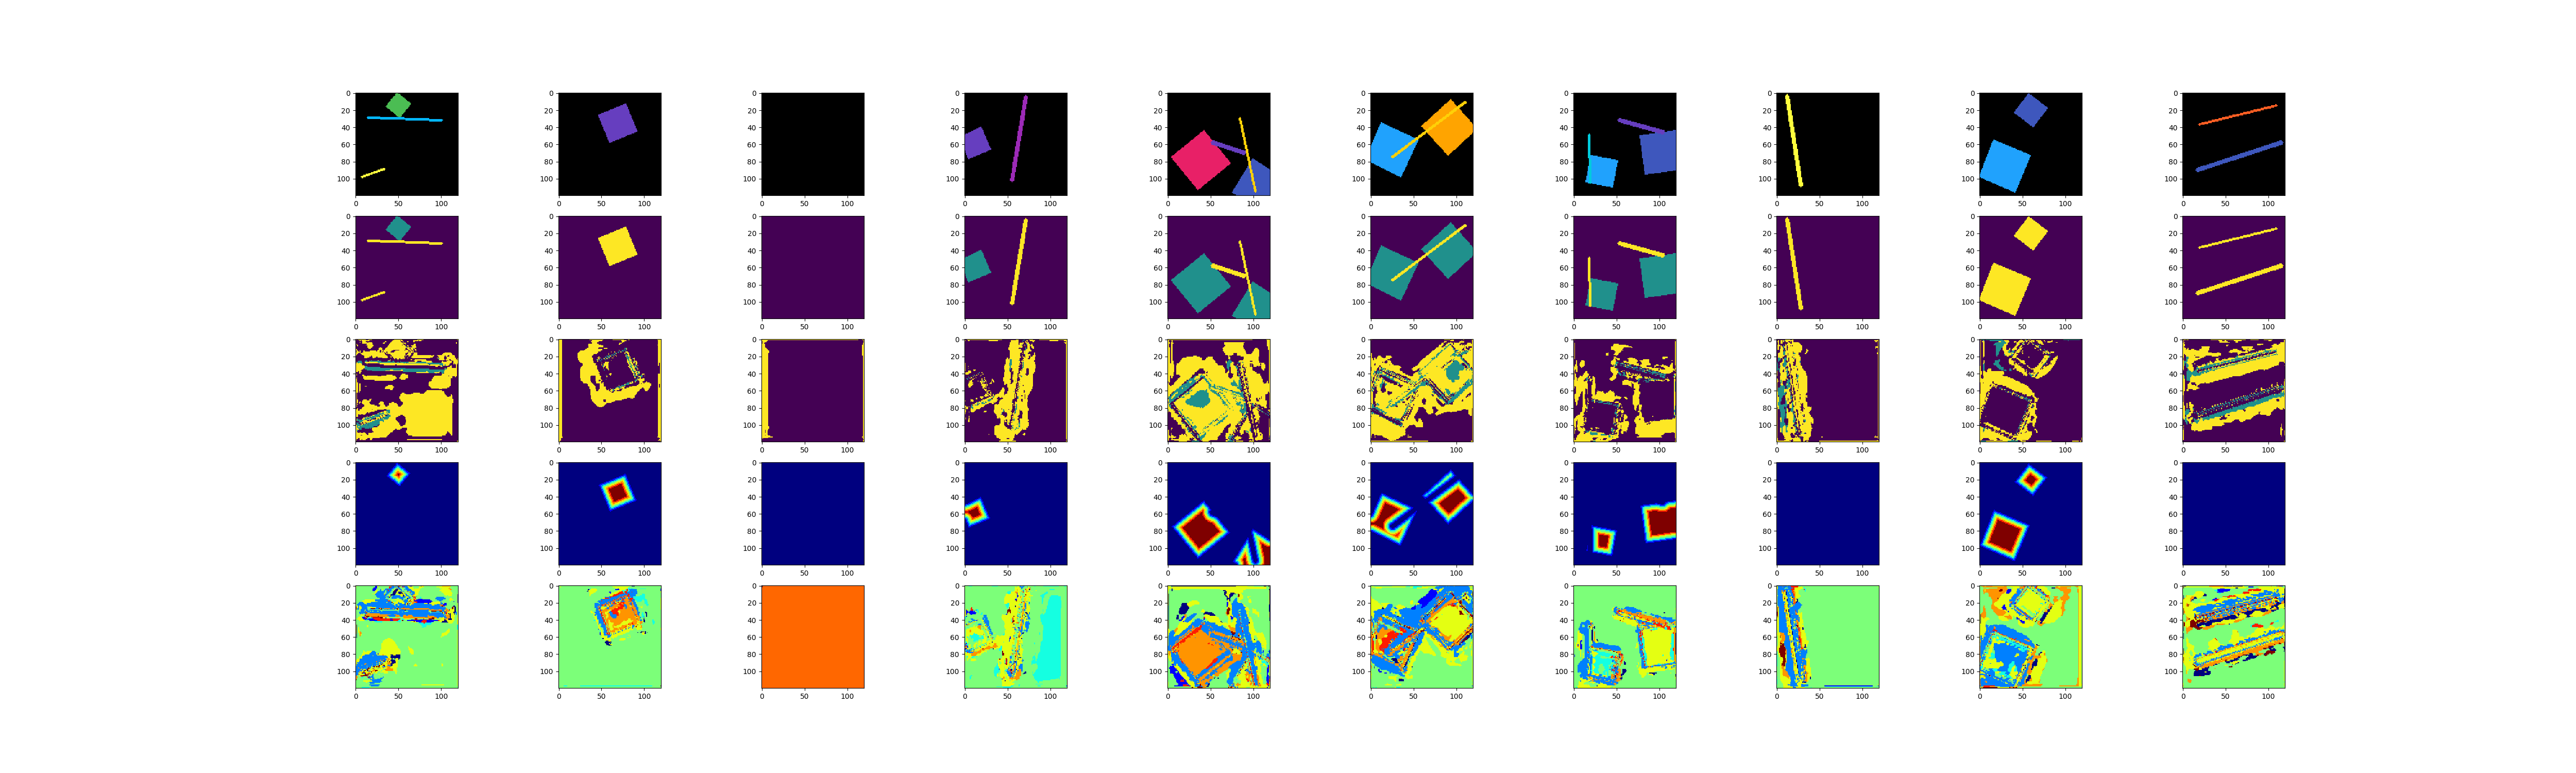

2018-04-20 16:27:58,236 Verification  loss= 3.4009,error= 45.6%
2018-04-20 16:27:58,240 Start optimization


Model trained from scratch


2018-04-20 16:27:58,847 Iter 0, Minibatch Loss= 2.8786, Minibatch error= 4.4%
2018-04-20 16:28:06,397 Iter 10, Minibatch Loss= 1.3074, Minibatch error= 5.4%
2018-04-20 16:28:14,315 Iter 20, Minibatch Loss= 0.4616, Minibatch error= 2.2%
2018-04-20 16:28:22,019 Iter 30, Minibatch Loss= 0.2316, Minibatch error= 1.8%
2018-04-20 16:28:29,629 Iter 40, Minibatch Loss= 0.1494, Minibatch error= 1.2%
2018-04-20 16:28:37,522 Iter 50, Minibatch Loss= 0.1226, Minibatch error= 0.7%
2018-04-20 16:28:45,193 Iter 60, Minibatch Loss= 0.1593, Minibatch error= 0.7%
2018-04-20 16:28:52,954 Iter 70, Minibatch Loss= 0.1314, Minibatch error= 0.4%
2018-04-20 16:29:00,911 Iter 80, Minibatch Loss= 0.1082, Minibatch error= 0.2%
2018-04-20 16:29:08,324 Iter 90, Minibatch Loss= 0.0890, Minibatch error= 0.2%
2018-04-20 16:29:16,507 Iter 100, Minibatch Loss= 0.1054, Minibatch error= 0.2%
2018-04-20 16:29:24,061 Iter 110, Minibatch Loss= 0.0781, Minibatch error= 0.2%
2018-04-20 16:29:31,685 Iter 120, Minibatch Loss= 0

<IPython.core.display.Javascript object>


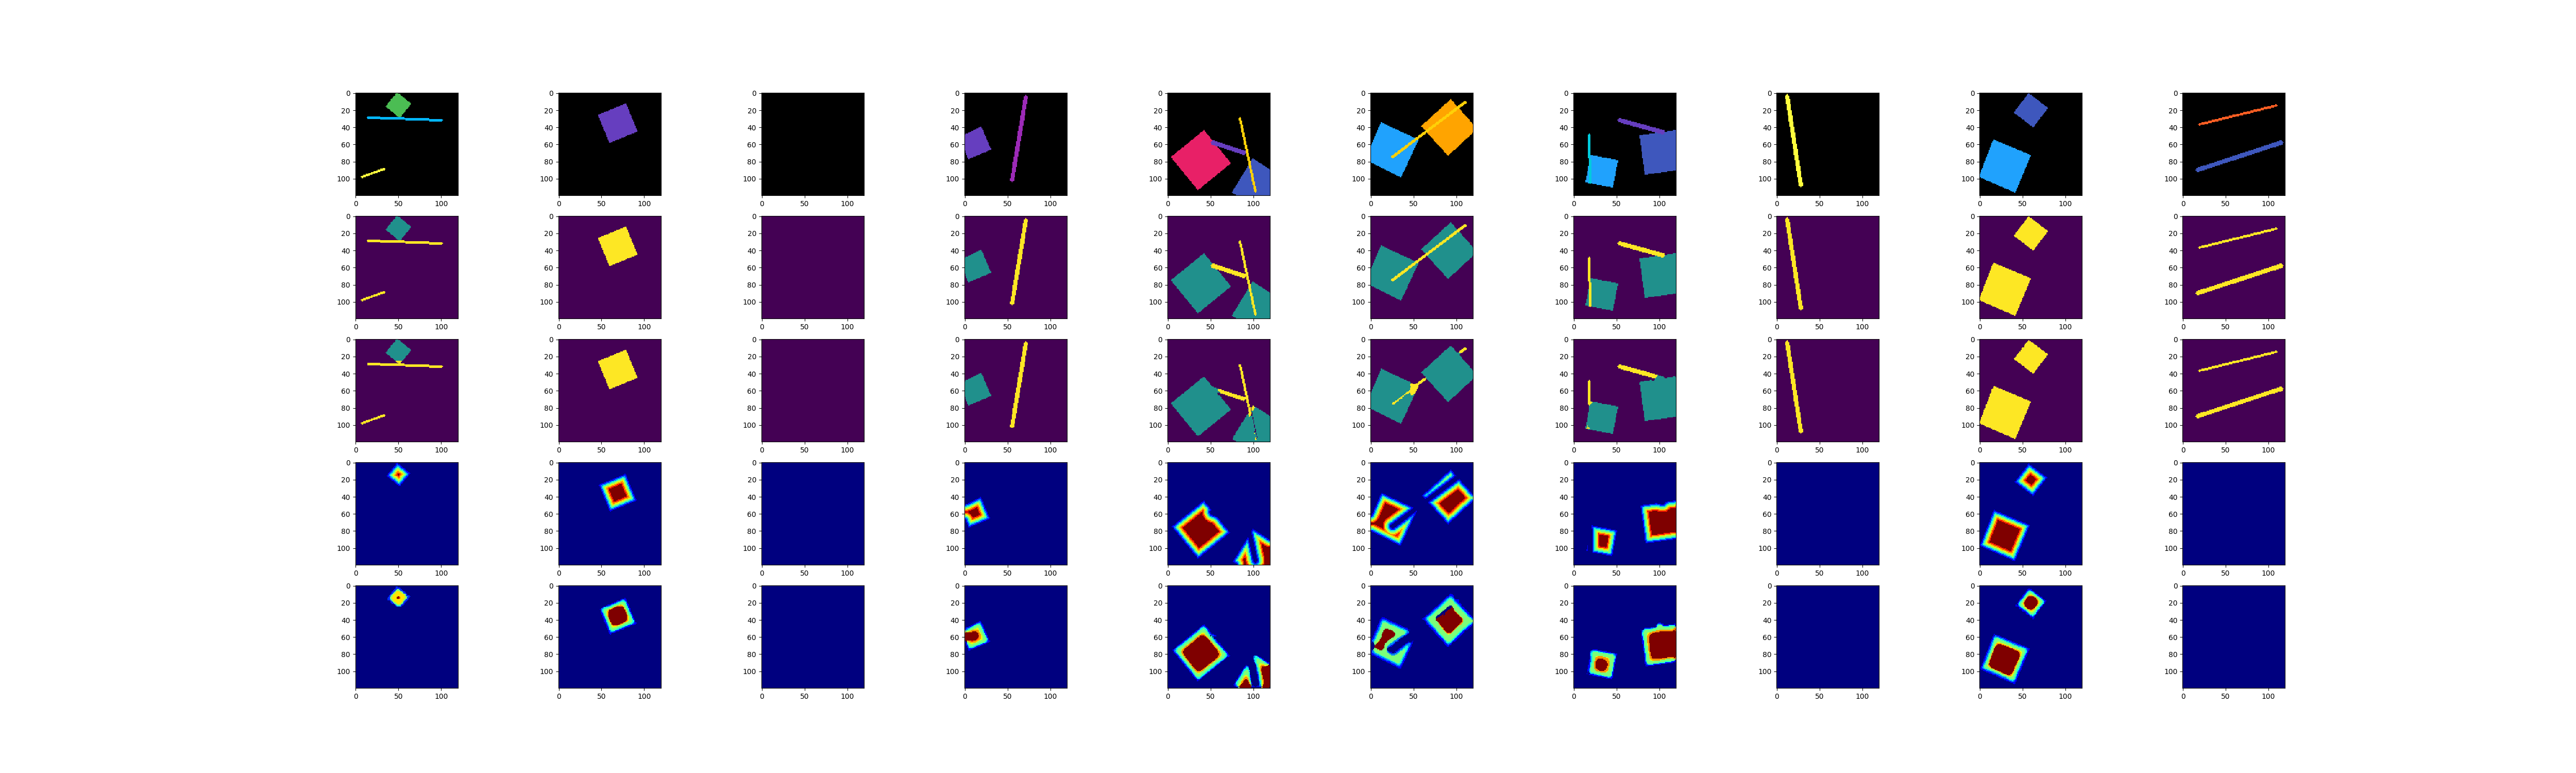

2018-04-20 16:30:19,145 Verification  loss= 0.1054,error rate= 0.2%, IOU = 0.9359, IOU Precision = 95.2460%, F1 IOU= 87.2596%
2018-04-20 16:30:19,806 Iter 0, Minibatch Loss= 0.1143, Minibatch error= 0.2%
2018-04-20 16:30:27,657 Iter 10, Minibatch Loss= 0.0521, Minibatch error= 0.2%
2018-04-20 16:30:35,222 Iter 20, Minibatch Loss= 0.0508, Minibatch error= 0.1%
2018-04-20 16:30:43,490 Iter 30, Minibatch Loss= 0.0643, Minibatch error= 0.2%
2018-04-20 16:30:51,087 Iter 40, Minibatch Loss= 0.0618, Minibatch error= 0.2%


Checkpoint 200 saved !


2018-04-20 16:30:59,662 Iter 50, Minibatch Loss= 0.0416, Minibatch error= 0.1%
2018-04-20 16:31:07,836 Iter 60, Minibatch Loss= 0.0715, Minibatch error= 0.2%
2018-04-20 16:31:15,361 Iter 70, Minibatch Loss= 0.0728, Minibatch error= 0.3%
2018-04-20 16:31:23,164 Iter 80, Minibatch Loss= 0.0493, Minibatch error= 0.1%
2018-04-20 16:31:30,967 Iter 90, Minibatch Loss= 0.0462, Minibatch error= 0.1%
2018-04-20 16:31:38,562 Iter 100, Minibatch Loss= 0.0562, Minibatch error= 0.2%
2018-04-20 16:31:46,410 Iter 110, Minibatch Loss= 0.0427, Minibatch error= 0.1%
2018-04-20 16:31:54,258 Iter 120, Minibatch Loss= 0.0475, Minibatch error= 0.2%
2018-04-20 16:32:01,961 Iter 130, Minibatch Loss= 0.0463, Minibatch error= 0.1%
2018-04-20 16:32:09,910 Iter 140, Minibatch Loss= 0.0423, Minibatch error= 0.1%
2018-04-20 16:32:17,566 Iter 150, Minibatch Loss= 0.0697, Minibatch error= 0.2%
2018-04-20 16:32:22,841  Training epoch_1, Minibatch Loss= 0.0581


<IPython.core.display.Javascript object>


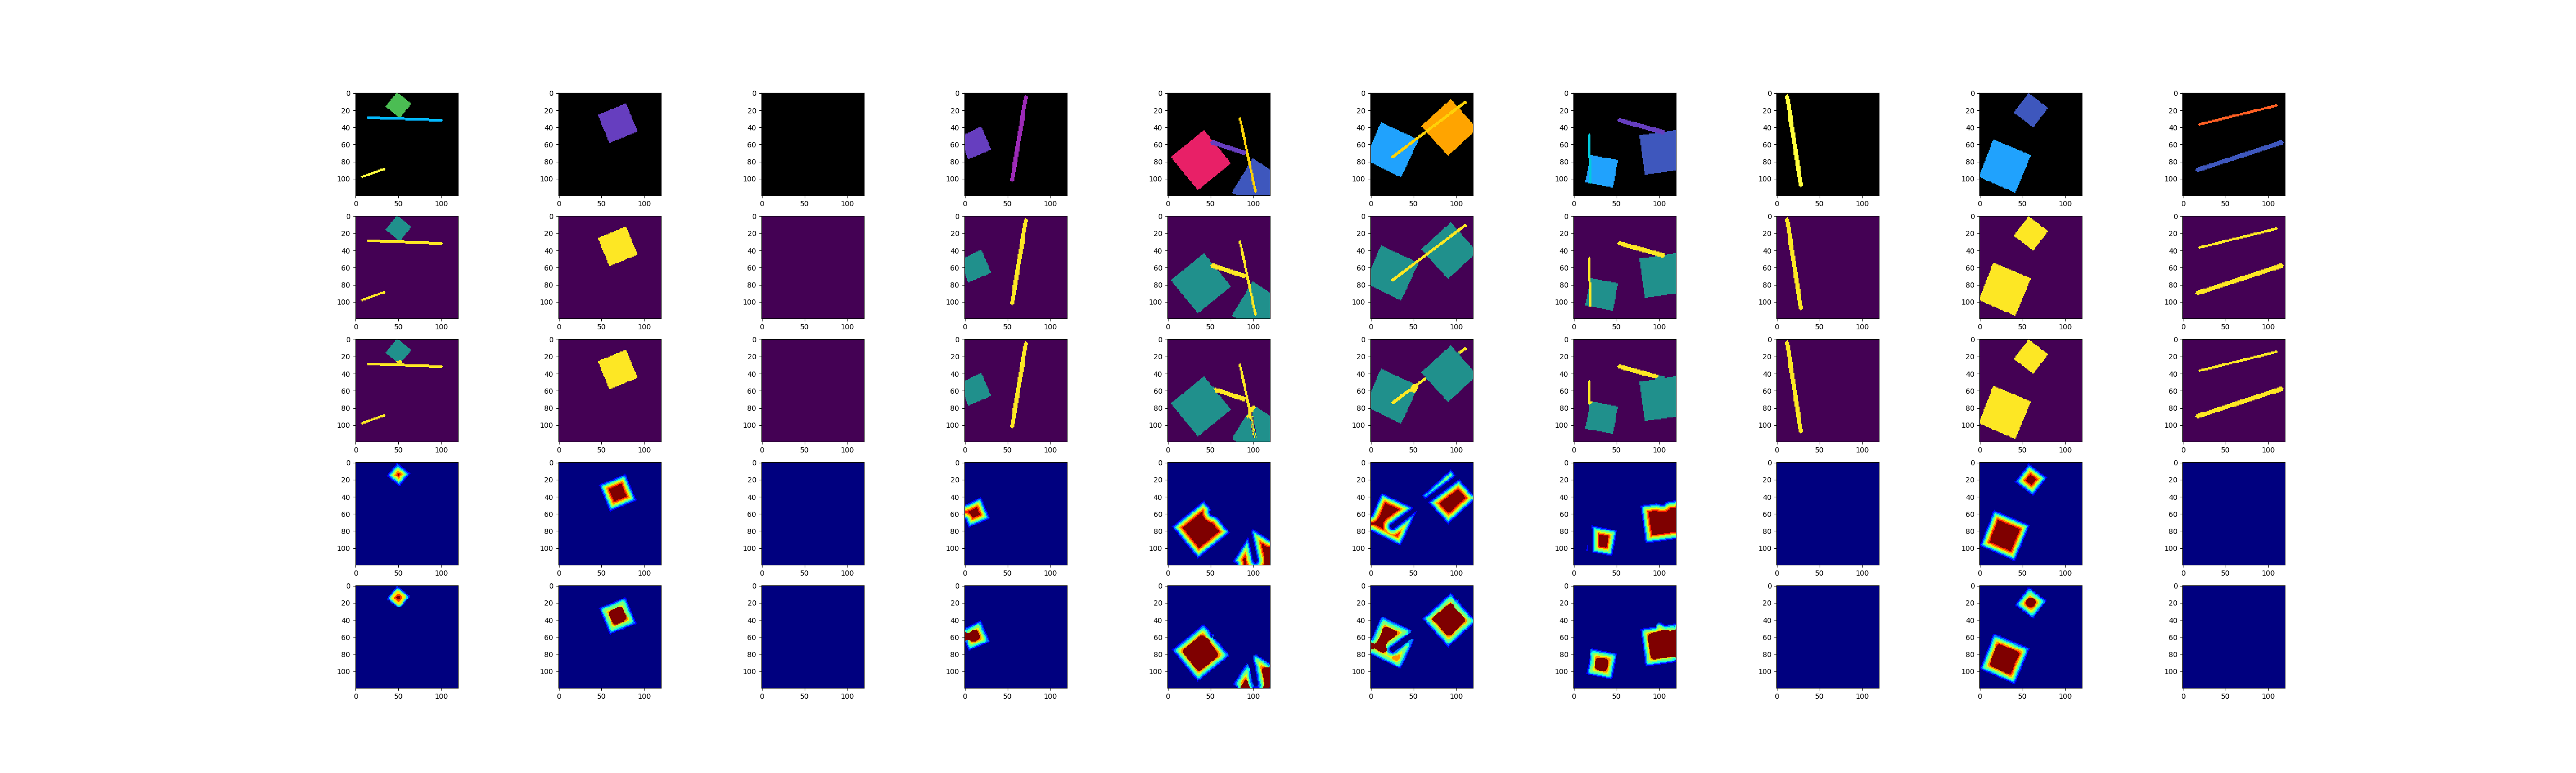

2018-04-20 16:32:50,042 Verification  loss= 0.0743,error rate= 0.2%, IOU = 0.9384, IOU Precision = 95.0794%, F1 IOU= 90.5196%
2018-04-20 16:32:50,665 Iter 0, Minibatch Loss= 0.0656, Minibatch error= 0.2%
2018-04-20 16:32:58,556 Iter 10, Minibatch Loss= 0.0329, Minibatch error= 0.1%
2018-04-20 16:33:06,071 Iter 20, Minibatch Loss= 0.0363, Minibatch error= 0.1%
2018-04-20 16:33:14,052 Iter 30, Minibatch Loss= 0.0457, Minibatch error= 0.2%
2018-04-20 16:33:22,077 Iter 40, Minibatch Loss= 0.0483, Minibatch error= 0.2%
2018-04-20 16:33:29,638 Iter 50, Minibatch Loss= 0.0252, Minibatch error= 0.0%
2018-04-20 16:33:37,627 Iter 60, Minibatch Loss= 0.0495, Minibatch error= 0.1%
2018-04-20 16:33:45,355 Iter 70, Minibatch Loss= 0.0541, Minibatch error= 0.2%
2018-04-20 16:33:52,970 Iter 80, Minibatch Loss= 0.0320, Minibatch error= 0.1%


Checkpoint 400 saved !


2018-04-20 16:34:00,824 Iter 90, Minibatch Loss= 0.0363, Minibatch error= 0.1%
2018-04-20 16:34:08,423 Iter 100, Minibatch Loss= 0.0425, Minibatch error= 0.1%
2018-04-20 16:34:16,140 Iter 110, Minibatch Loss= 0.0328, Minibatch error= 0.1%
2018-04-20 16:34:24,106 Iter 120, Minibatch Loss= 0.0342, Minibatch error= 0.1%
2018-04-20 16:34:31,760 Iter 130, Minibatch Loss= 0.0421, Minibatch error= 0.1%
2018-04-20 16:34:39,418 Iter 140, Minibatch Loss= 0.0309, Minibatch error= 0.1%
2018-04-20 16:34:47,432 Iter 150, Minibatch Loss= 0.0529, Minibatch error= 0.2%
2018-04-20 16:34:52,727  Training epoch_2, Minibatch Loss= 0.0413


<IPython.core.display.Javascript object>


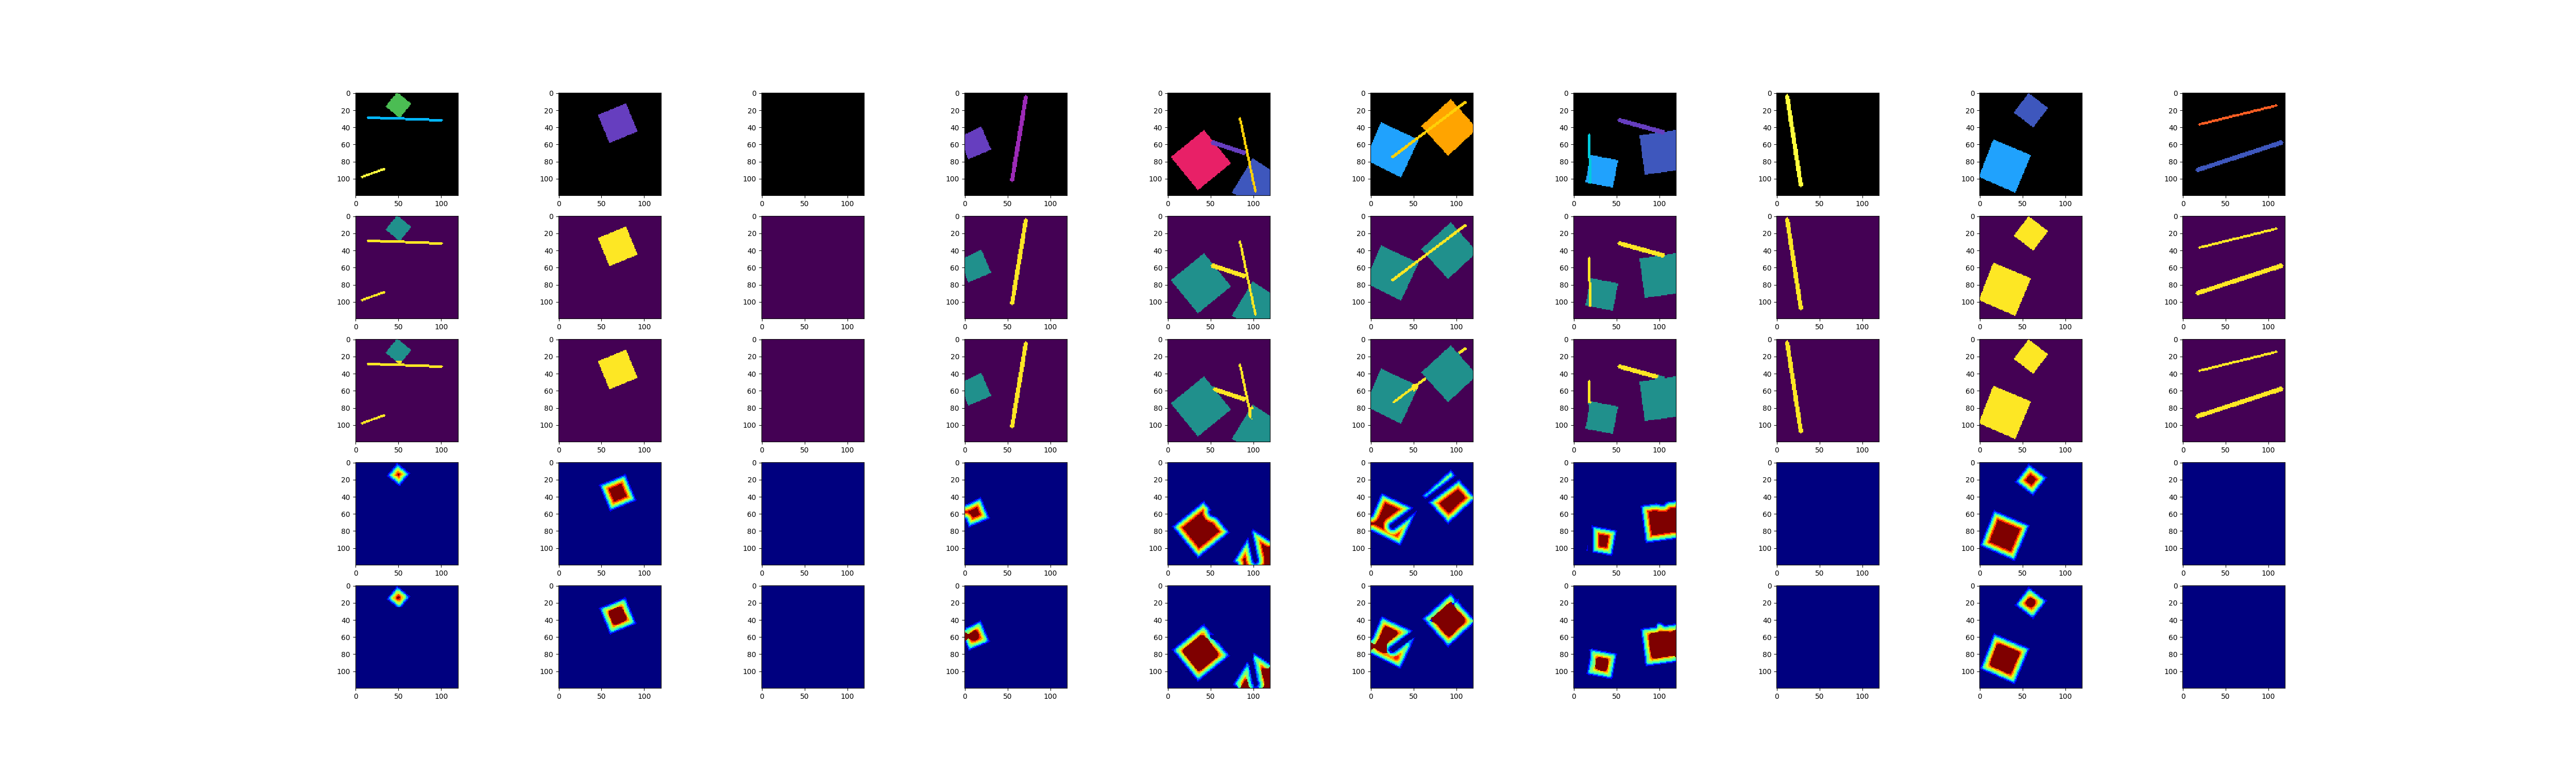

2018-04-20 16:35:21,838 Verification  loss= 0.0567,error rate= 0.1%, IOU = 0.9536, IOU Precision = 96.4683%, F1 IOU= 94.5272%
2018-04-20 16:35:22,500 Iter 0, Minibatch Loss= 0.0490, Minibatch error= 0.1%
2018-04-20 16:35:30,483 Iter 10, Minibatch Loss= 0.0226, Minibatch error= 0.1%
2018-04-20 16:35:37,996 Iter 20, Minibatch Loss= 0.0281, Minibatch error= 0.0%
2018-04-20 16:35:45,840 Iter 30, Minibatch Loss= 0.0337, Minibatch error= 0.2%
2018-04-20 16:35:53,780 Iter 40, Minibatch Loss= 0.0391, Minibatch error= 0.1%
2018-04-20 16:36:01,410 Iter 50, Minibatch Loss= 0.0170, Minibatch error= 0.0%
2018-04-20 16:36:09,446 Iter 60, Minibatch Loss= 0.0398, Minibatch error= 0.1%
2018-04-20 16:36:17,242 Iter 70, Minibatch Loss= 0.0452, Minibatch error= 0.1%
2018-04-20 16:36:24,890 Iter 80, Minibatch Loss= 0.0236, Minibatch error= 0.1%
2018-04-20 16:36:32,879 Iter 90, Minibatch Loss= 0.0275, Minibatch error= 0.1%
2018-04-20 16:36:40,499 Iter 100, Minibatch Loss= 0.0284, Minibatch error= 0.1%
2018-

Checkpoint 600 saved !


2018-04-20 16:37:12,171 Iter 140, Minibatch Loss= 0.0260, Minibatch error= 0.1%
2018-04-20 16:37:20,174 Iter 150, Minibatch Loss= 0.0433, Minibatch error= 0.2%
2018-04-20 16:37:25,609  Training epoch_3, Minibatch Loss= 0.0326


<IPython.core.display.Javascript object>


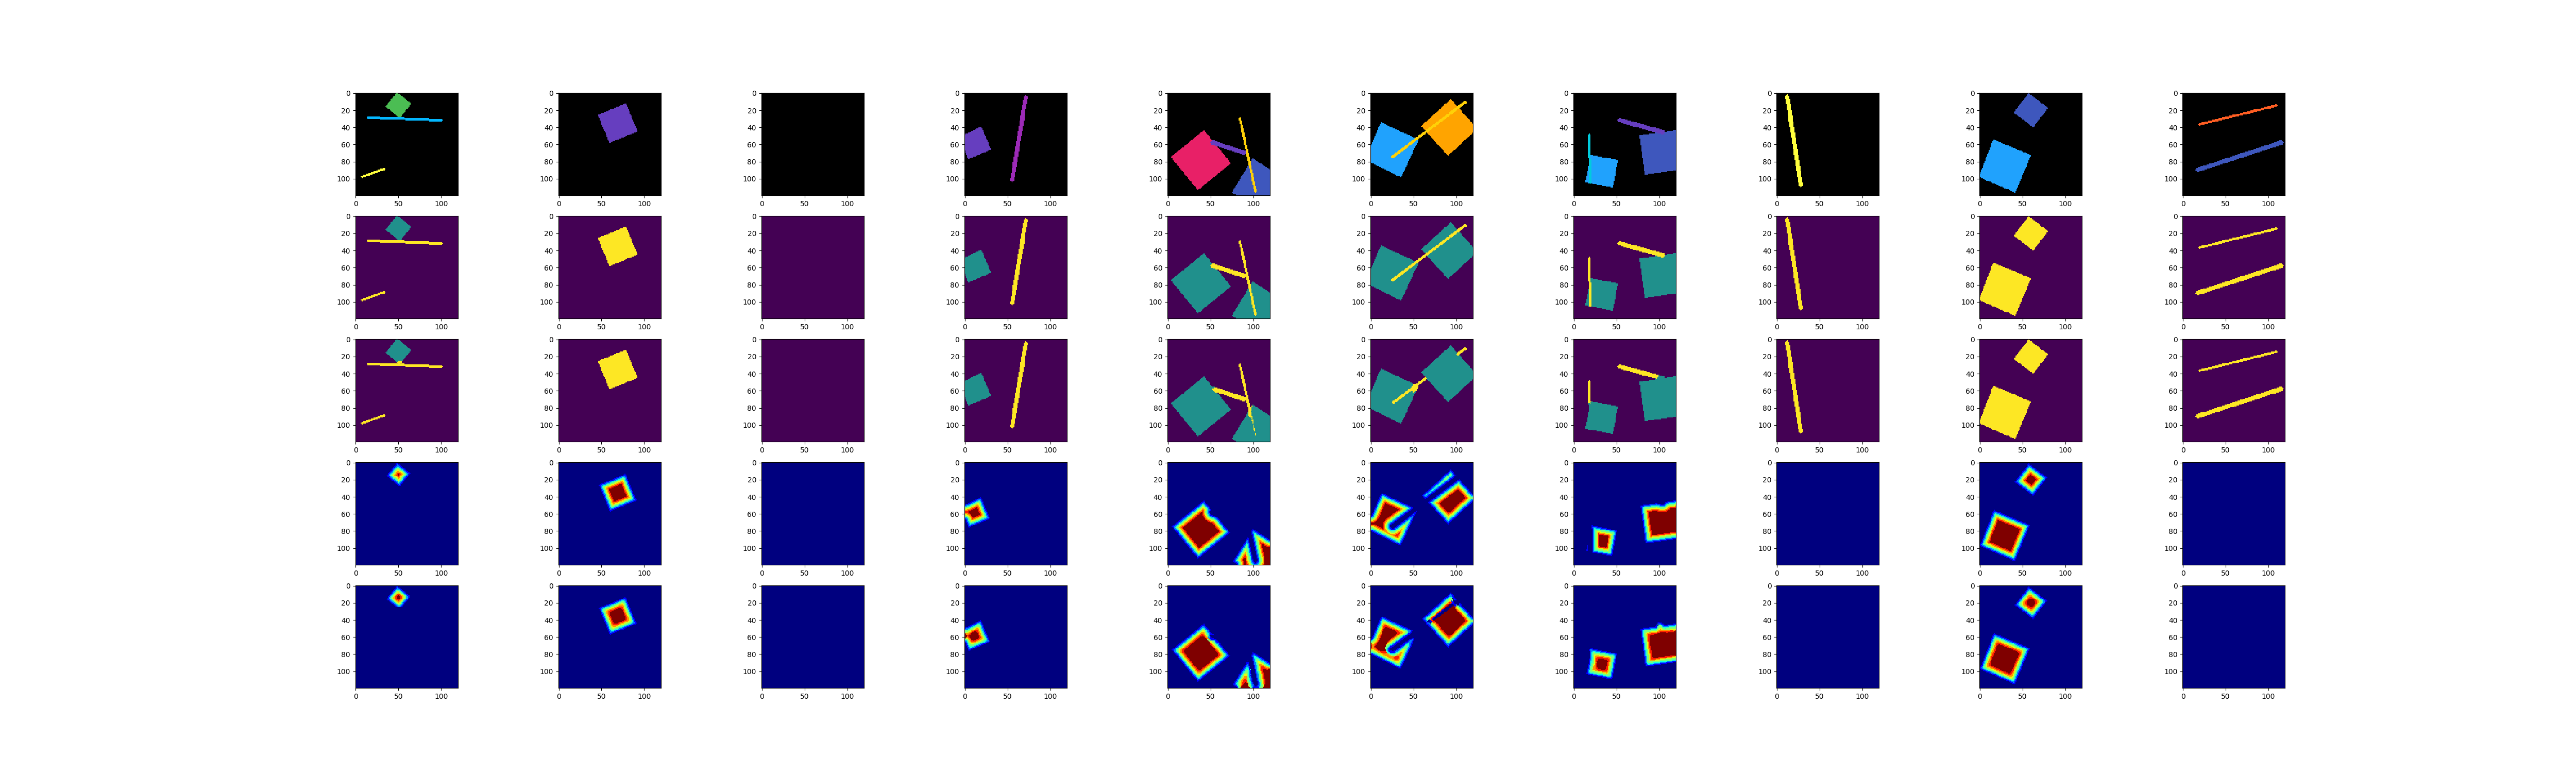

2018-04-20 16:37:53,126 Verification  loss= 0.0463,error rate= 0.1%, IOU = 0.9594, IOU Precision = 96.9444%, F1 IOU= 94.0592%
2018-04-20 16:37:53,753 Iter 0, Minibatch Loss= 0.0427, Minibatch error= 0.1%
2018-04-20 16:38:01,736 Iter 10, Minibatch Loss= 0.0181, Minibatch error= 0.1%
2018-04-20 16:38:09,039 Iter 20, Minibatch Loss= 0.0231, Minibatch error= 0.0%
2018-04-20 16:38:16,931 Iter 30, Minibatch Loss= 0.0254, Minibatch error= 0.1%
2018-04-20 16:38:24,954 Iter 40, Minibatch Loss= 0.0301, Minibatch error= 0.1%
2018-04-20 16:38:32,351 Iter 50, Minibatch Loss= 0.0136, Minibatch error= 0.0%
2018-04-20 16:38:40,299 Iter 60, Minibatch Loss= 0.0338, Minibatch error= 0.1%
2018-04-20 16:38:48,156 Iter 70, Minibatch Loss= 0.0411, Minibatch error= 0.1%
2018-04-20 16:38:55,695 Iter 80, Minibatch Loss= 0.0193, Minibatch error= 0.0%
2018-04-20 16:39:03,541 Iter 90, Minibatch Loss= 0.0213, Minibatch error= 0.1%
2018-04-20 16:39:11,182 Iter 100, Minibatch Loss= 0.0237, Minibatch error= 0.1%
2018-

<IPython.core.display.Javascript object>


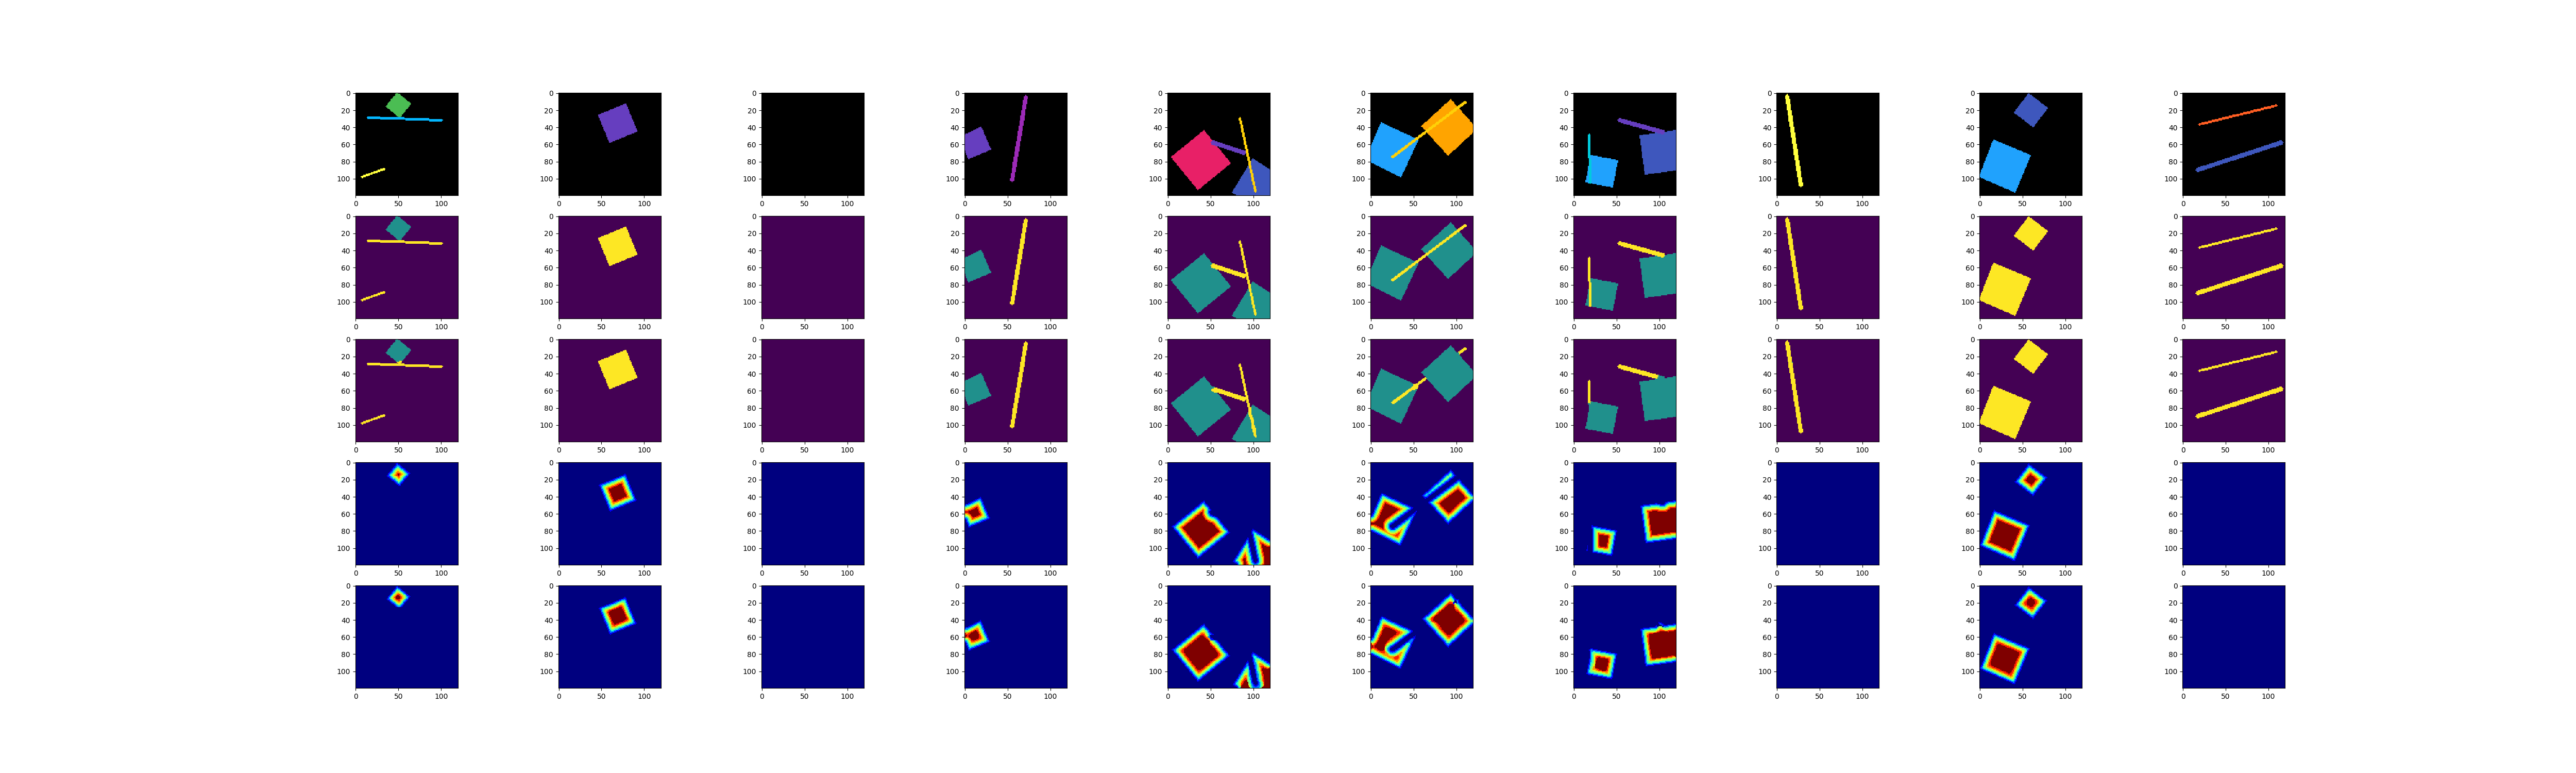

2018-04-20 16:40:24,904 Verification  loss= 0.0448,error rate= 0.1%, IOU = 0.9612, IOU Precision = 96.9444%, F1 IOU= 94.5631%
2018-04-20 16:40:25,568 Iter 0, Minibatch Loss= 0.0392, Minibatch error= 0.1%
2018-04-20 16:40:33,583 Iter 10, Minibatch Loss= 0.0152, Minibatch error= 0.1%
2018-04-20 16:40:41,124 Iter 20, Minibatch Loss= 0.0183, Minibatch error= 0.0%


Checkpoint 800 saved !


2018-04-20 16:40:49,217 Iter 30, Minibatch Loss= 0.0197, Minibatch error= 0.1%
2018-04-20 16:40:57,266 Iter 40, Minibatch Loss= 0.0274, Minibatch error= 0.1%
2018-04-20 16:41:04,869 Iter 50, Minibatch Loss= 0.0116, Minibatch error= 0.0%
2018-04-20 16:41:12,953 Iter 60, Minibatch Loss= 0.0248, Minibatch error= 0.1%
2018-04-20 16:41:20,678 Iter 70, Minibatch Loss= 0.0349, Minibatch error= 0.1%
2018-04-20 16:41:28,361 Iter 80, Minibatch Loss= 0.0156, Minibatch error= 0.0%
2018-04-20 16:41:36,239 Iter 90, Minibatch Loss= 0.0192, Minibatch error= 0.1%
2018-04-20 16:41:44,018 Iter 100, Minibatch Loss= 0.0182, Minibatch error= 0.1%
2018-04-20 16:41:51,587 Iter 110, Minibatch Loss= 0.0142, Minibatch error= 0.0%
2018-04-20 16:41:59,535 Iter 120, Minibatch Loss= 0.0182, Minibatch error= 0.1%
2018-04-20 16:42:07,265 Iter 130, Minibatch Loss= 0.0237, Minibatch error= 0.1%
2018-04-20 16:42:14,958 Iter 140, Minibatch Loss= 0.0207, Minibatch error= 0.1%
2018-04-20 16:42:23,026 Iter 150, Minibatch Los

<IPython.core.display.Javascript object>


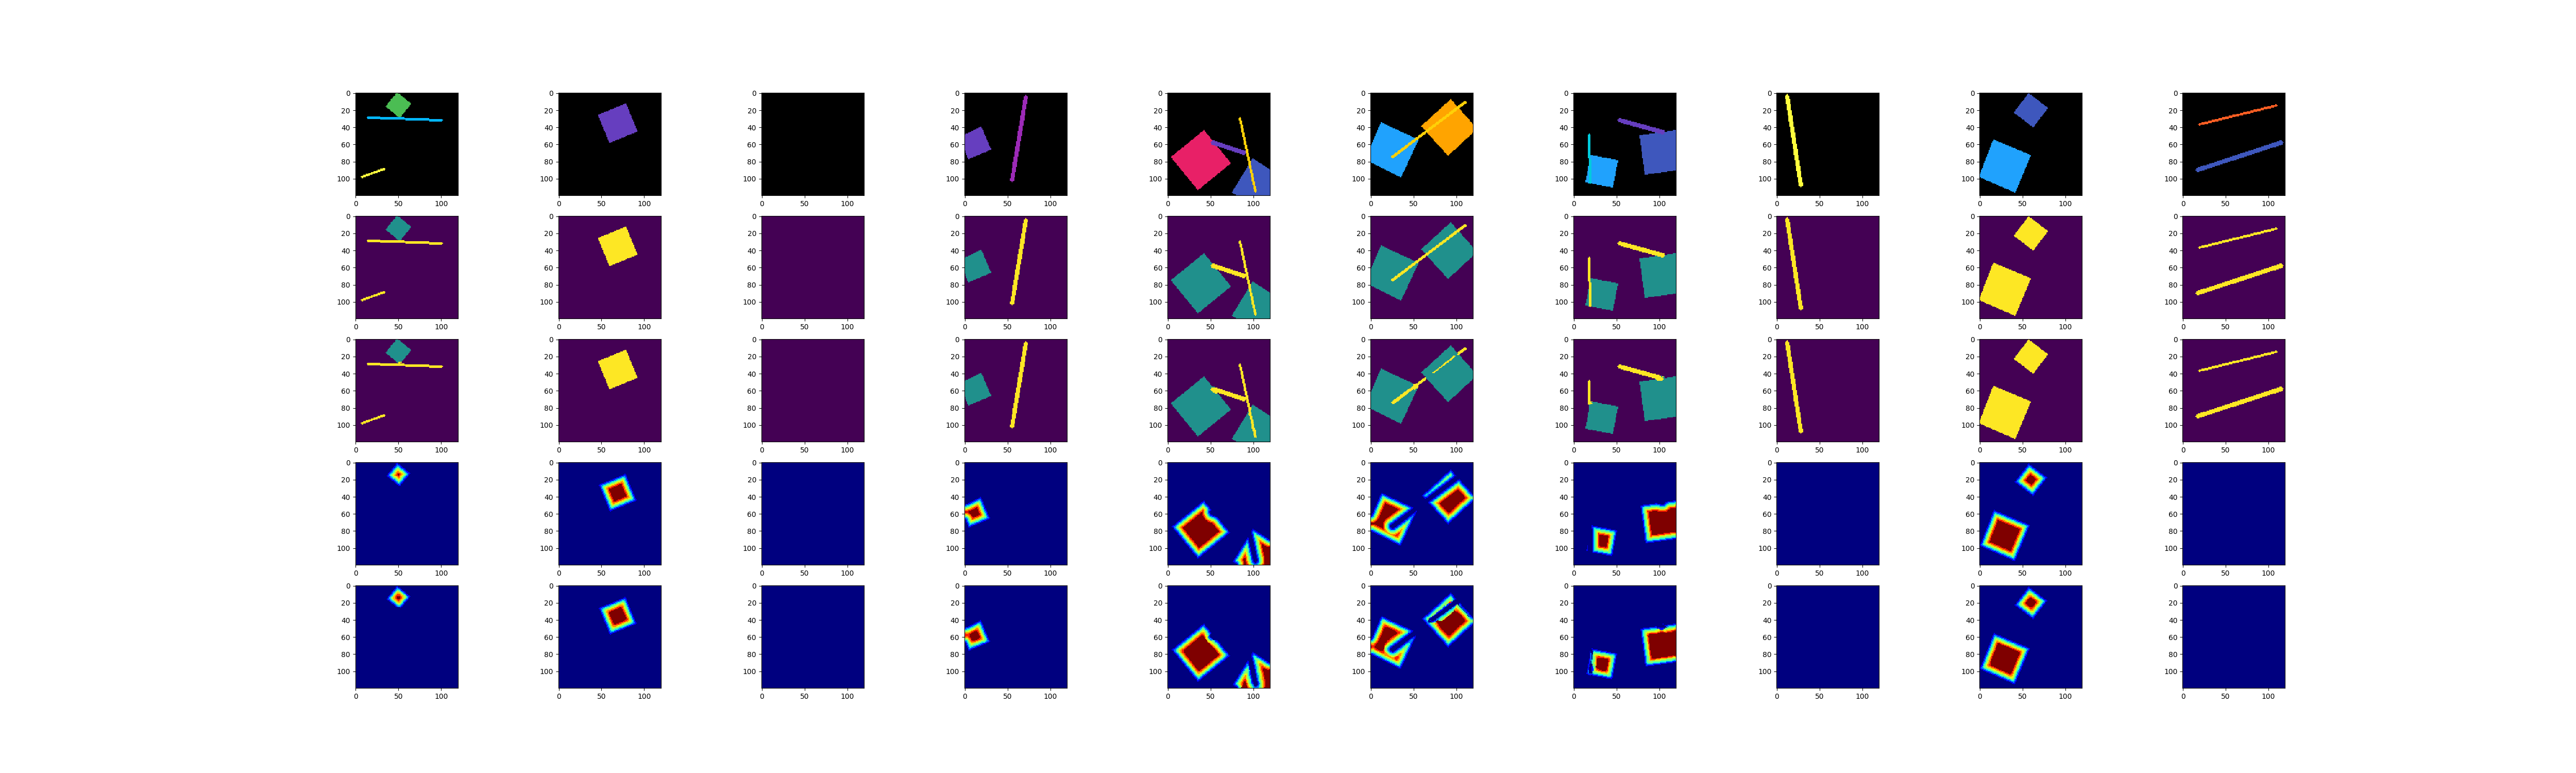

2018-04-20 16:42:59,177 Verification  loss= 0.0337,error rate= 0.1%, IOU = 0.9624, IOU Precision = 96.9444%, F1 IOU= 95.9402%


<IPython.core.display.Javascript object>


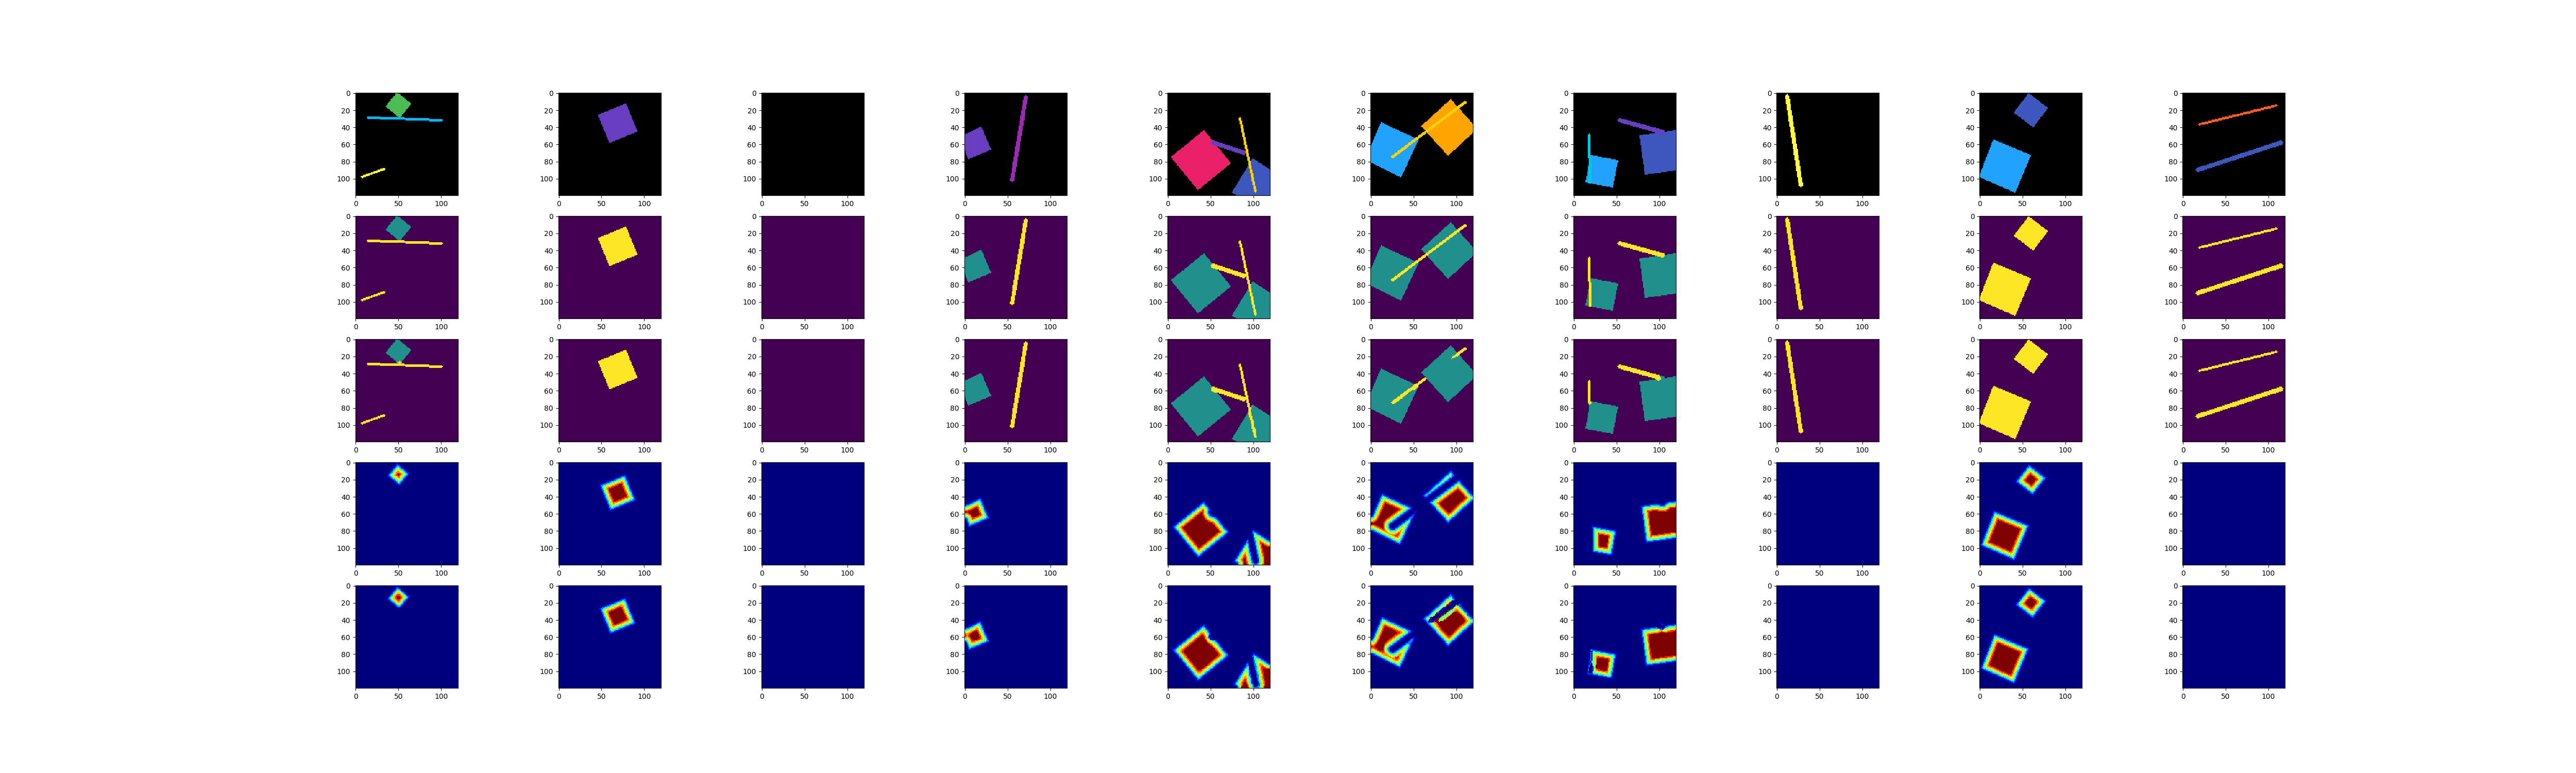

2018-04-20 16:43:22,699 Verification  loss= 0.0351,error rate= 0.1%, IOU = 0.9619, IOU Precision = 96.9444%, F1 IOU= 95.6161%


Last model saved is MODEL_SHAPE_DIST_TEST/pytorch_shape_test_DIST: 


<IPython.core.display.Javascript object>


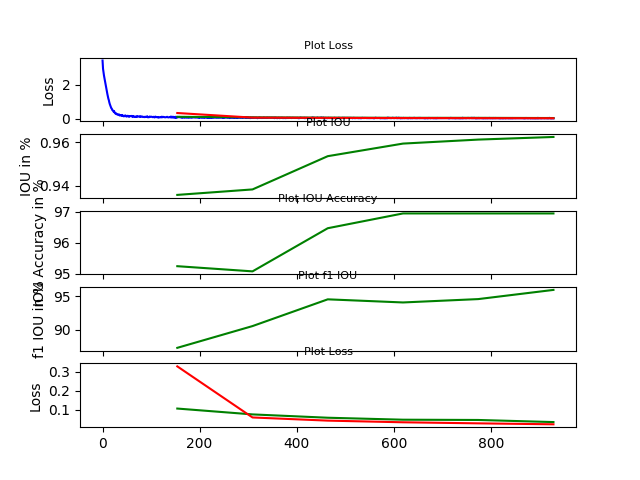

In [25]:
if __name__ == '__main__':

    %matplotlib notebook
    model=UNet(INPUT_CHANNELS,NB_CLASSES,depth =DEFAULT_LAYERS,n_features_zero =DEFAULT_FEATURES_ROOT,width_kernel=DEFAULT_FILTER_WIDTH,dropout=DROPOUT,distance_net=True,bins=BINS)
#     model.apply(weights_init)
    model.cuda()
    cudnn.benchmark = True
    trainer=Trainer(model,DEFAULT_BATCH_SIZE,DEFAULT_LR,NB_CLASSES)
    save_path,loss_train,avg_loss_train,loss_verif,iou_verif,iou_acc_verif,f1_iou_verif=trainer.train(  MODEL_PATH_SAVE, MODEL_PATH_RESTORE,DEFAULT_EPOCHS,DROPOUT, DISPLAY_STEP, DEFAULT_VALID,REC_SAVE, TEST_SAVE,threshold=THRESHOLD,bins=BINS)
    print('Last model saved is %s: '%save_path)
    fig, axs = plt.subplots(5, sharex=True)

    
    #SAVE loss

    axs[0].set_title('Plot Loss', fontsize=8)
    ite = np.arange(0,len(loss_train),1)
    epo=np.arange(int(len(loss_train)/DEFAULT_EPOCHS)-1,len(loss_train),int(len(loss_train)/DEFAULT_EPOCHS))
    axs[0].plot(ite,loss_train,'b',epo,loss_verif,'g',epo,avg_loss_train,'r')
    axs[0].set_ylabel('Loss')

    
     #SAVE IOU

    axs[1].set_title('Plot IOU', fontsize=8)
    epo=np.arange(int(len(loss_train)/len(iou_verif))-1,len(loss_train),int(len(loss_train)/len(iou_verif)))
    axs[1].plot(epo,iou_verif,'g')
    axs[1].set_ylabel('IOU in %')

    
    #SAVE IOU  acc

    axs[2].set_title('Plot IOU Accuracy', fontsize=8)
    epo=np.arange(int(len(loss_train)/len(iou_acc_verif))-1,len(loss_train),int(len(loss_train)/len(iou_acc_verif)))
    axs[2].plot(epo,iou_acc_verif,'g')
    axs[2].set_ylabel('IOU Accuracy in %')
    


    
     #SAVE f1 IOU

    axs[3].set_title('Plot f1 IOU', fontsize=8)
    epo=np.arange(int(len(loss_train)/len(f1_iou_verif))-1,len(loss_train),int(len(loss_train)/len(f1_iou_verif)))
    axs[3].plot(epo,f1_iou_verif,'g')
    axs[3].set_ylabel('f1 IOU in %')
    
    
     #SAVE loss 2

    axs[4].set_title('Plot Loss', fontsize=8)
    epo=np.arange(int(len(loss_train)/DEFAULT_EPOCHS)-1,len(loss_train),int(len(loss_train)/DEFAULT_EPOCHS))
    axs[4].plot(epo,loss_verif,'g',epo,avg_loss_train,'r')
    axs[4].set_ylabel('Loss')

    
    fig.canvas.draw()
    time.sleep(1)
    plt.close(fig)

